# Graph optimization with QAOA

One application area where near-term quantum hardware is expected to shine is in graph optimization. Graph-based problems are interesting to explore because they have both strong links to practical use-cases (such as logistics and social networks) and are also often hard to solve.

<div align="center"><img src="graphs.png"/></div>

Graphs are composed of a collection of interconnected nodes. For example, here is a six-node graph:

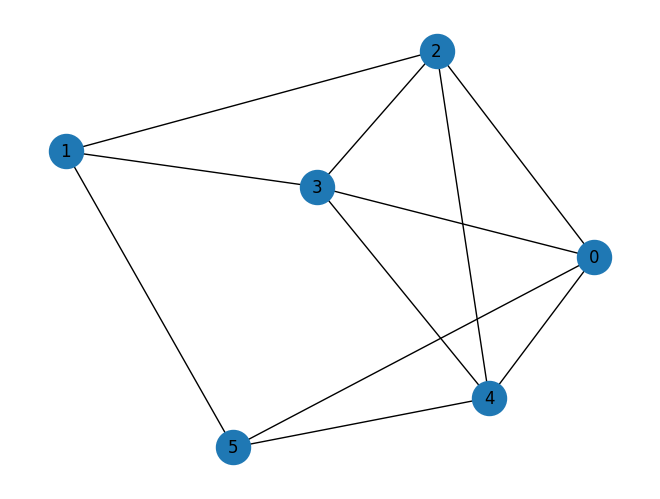

In [1]:
import networkx as nx

n_nodes = 6
p = 0.5  # probability of an edge
seed = 1967

g = nx.erdos_renyi_graph(n_nodes, p=p, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions, node_size=600)

Many practical use-cases can be mapped to a graph structure. In a social network, the nodes of a graph can represent users and the edges can represent connections between the users.

We often need to solve optimization problems to identify important properties of the graph. These problems can include:

- finding large clusters of fully connected nodes (known as [maximum clique](https://en.wikipedia.org/wiki/Clique_problem))
- finding a minimum number of nodes that connect to every edge in the graph (known as [minimum vertex cover](https://en.wikipedia.org/wiki/Vertex_cover))
- finding a partition of the nodes into two subsets so that the greatest number of edges are intersected (known as [maximum cut](https://en.wikipedia.org/wiki/Maximum_cut))

This tutorial shows how a quantum algorithm called QAOA can be run using PennyLane and Braket to solve graph-based optimization problems. We begin with a small 6-node graph and then push the limits to run a 20-node graph using parallel executions on SV1.

<div class="alert alert-block alert-info">
<b>Note</b> This notebook requires PennyLane version 0.17 or above.
</div>

## QAOA

The quantum approximate optimization algorithm (QAOA) is an algorithm designed for near-term hardware. It can find approximate solutions to combinatorial optimization problems such as graph-based problems.

QAOA is covered in more depth in the [QAOA_braket](../../hybrid_quantum_algorithms/QAOA/QAOA_braket.ipynb) notebook as well as in PennyLane [tutorials](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html). The following is a short summary to refresh the key concepts.


QAOA begins by associating the optimization problem with a cost Hamiltonian $H_C$ and choosing a mixer Hamiltonian $H_{M}$. It proceeds by repetitively applying multiple layers of the unitaries $\exp{(-i \gamma_i H_C)}$ and $\exp{(-i \alpha_i H_M)}$ with controllable parameters $\gamma_i$ and $\alpha_i$, as shown in the diagram below.

<div align="center"><img src="qaoa.png"/></div>

The algorithm then measures the cost Hamiltonian $H_C$. By varying the controllable parameters $\gamma_i$ and $\alpha_i$, the expectation value of the cost Hamiltonian is minimized. Applying the optimized unitaries prepares a quantum state that contains information about the optimal configuration for the problem. Sampling from the state will give a candidate solution.

<div class="alert alert-block alert-info">
<b>Summary</b> If you are less familiar with QAOA and quantum algorithms, the key takeaway message is that the algorithm involves an optimization of the controllable parameters $\gamma_i$ and $\alpha_i$ that the quantum circuit depends on. This can be tackled naturally using the PennyLane/Braket pipeline.
</div>

## Fixing the problem

Let's consider the graph above and aim to find the maximum clique, i.e., the largest set of nodes that are fully connected.

To solve this using QAOA in PennyLane and Braket, we first calculate the cost Hamiltonian $H_C$ and corresponding mixer Hamiltonian $H_M$

In [2]:
import pennylane as qml
from pennylane import numpy as np

cost_h, mixer_h = qml.qaoa.max_clique(g, constrained=False)
# constrained=True results in greater circuit depth but potentially better solutions

print("Cost Hamiltonian:\n", cost_h)
print("Mixer Hamiltonian:\n", mixer_h)

Cost Hamiltonian:
   (-0.5) [Z1]
+ (-0.5) [Z5]
+ (0.25) [Z0]
+ (0.25) [Z4]
+ (0.25) [Z2]
+ (0.25) [Z3]
+ (0.75) [Z0 Z1]
+ (0.75) [Z1 Z4]
+ (0.75) [Z2 Z5]
+ (0.75) [Z3 Z5]
Mixer Hamiltonian:
   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]


## Setting up the algorithm

We begin by setting up a single QAOA layer

<div align="center"><img src="qaoa_layer.png"/></div>

This layer contains the controllable parameters $\gamma_i$ and $\alpha_i$.

In [3]:
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

The full QAOA circuit is then given by:

In [4]:
n_layers = 1
wires = n_nodes


def circuit(params, **kwargs):
    for i in range(wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)

    qml.layer(qaoa_layer, n_layers, params[0], params[1])

<div class="alert alert-block alert-info">
<b>Note</b> We have chosen to use a single QAOA layer. The choice of depth is a tradeoff between improved solutions (for greater depth) and increasing runtime.
</div>

There are overall two controllable parameters: the first one is $\gamma_i$ of the cost Hamiltonian and the one is $\alpha_i$ of the mixer Hamiltonian:

In [5]:
np.random.seed(1967)
params = np.random.uniform(size=[2, n_layers])
params

tensor([[0.72511958],
        [0.57312068]], requires_grad=True)

For this part of the tutorial, we will use the local Braket simulator (see the [introduction tutorial](./0_Getting_started.ipynb) for further details):

In [6]:
dev = qml.device("braket.local.qubit", wires=wires)

The final step is to define the cost function. In QAOA, the output cost function is given by the expectation value of the cost Hamiltonian $H_C$, i.e.,

In [7]:
@qml.qnode(dev, diff_method="parameter-shift")
def cost_function(params, **kwargs):
    circuit(params)
    return qml.expval(cost_h)

## Running the algorithm

Now that we have set up the cost function, we just need to pick an optimizer and run the standard optimization loop.

In [8]:
optimizer = qml.GradientDescentOptimizer()

In [9]:
%%time
print("Initial cost:", cost_function(params))

for i in range(5):
    params = optimizer.step(cost_function, params)
    cost_eval = cost_function(params)
    print(f"Completed iteration {i + 1}, cost function:", cost_eval)

Initial cost: 1.2873831170401528
Completed iteration 1, cost function: 1.0283347453164076
Completed iteration 2, cost function: 0.6850453114142451
Completed iteration 3, cost function: 0.26816570914692445
Completed iteration 4, cost function: -0.18397174104834577
Completed iteration 5, cost function: -0.6134512514217036
CPU times: user 9.66 s, sys: 3.35 ms, total: 9.66 s
Wall time: 9.66 s


## Investigating the result

How do we know how well the algorithm has performed? To do this, we can sample from the circuit using the optimized parameters. This will give us binary samples that allow us to select which nodes of the graph to use as part of our clique, e.g., either by simply selecting the most common sample or selecting the sample with the lowest corresponding energy.

Let's take some samples and see which ones occur most frequently. To start, we'll create a QNode designed for sampling.

In [10]:
shots = 10_000
dev = qml.device("braket.local.qubit", wires=wires, shots=shots)


@qml.qnode(dev, diff_method="parameter-shift")
def samples(params):
    circuit(params)
    return np.array([qml.sample(qml.PauliZ(i)) for i in range(wires)])

Samples can now be generated and converted into probabilities:

In [11]:
from collections import Counter

s = samples(params).T
s = (1 - s.numpy()) / 2
s = map(tuple, s)

counts = Counter(s)
indx = np.ndindex(*[2] * wires)

probs = {p: counts.get(p, 0) / shots for p in indx}

We can now plot the probability distribution over all possible samples:

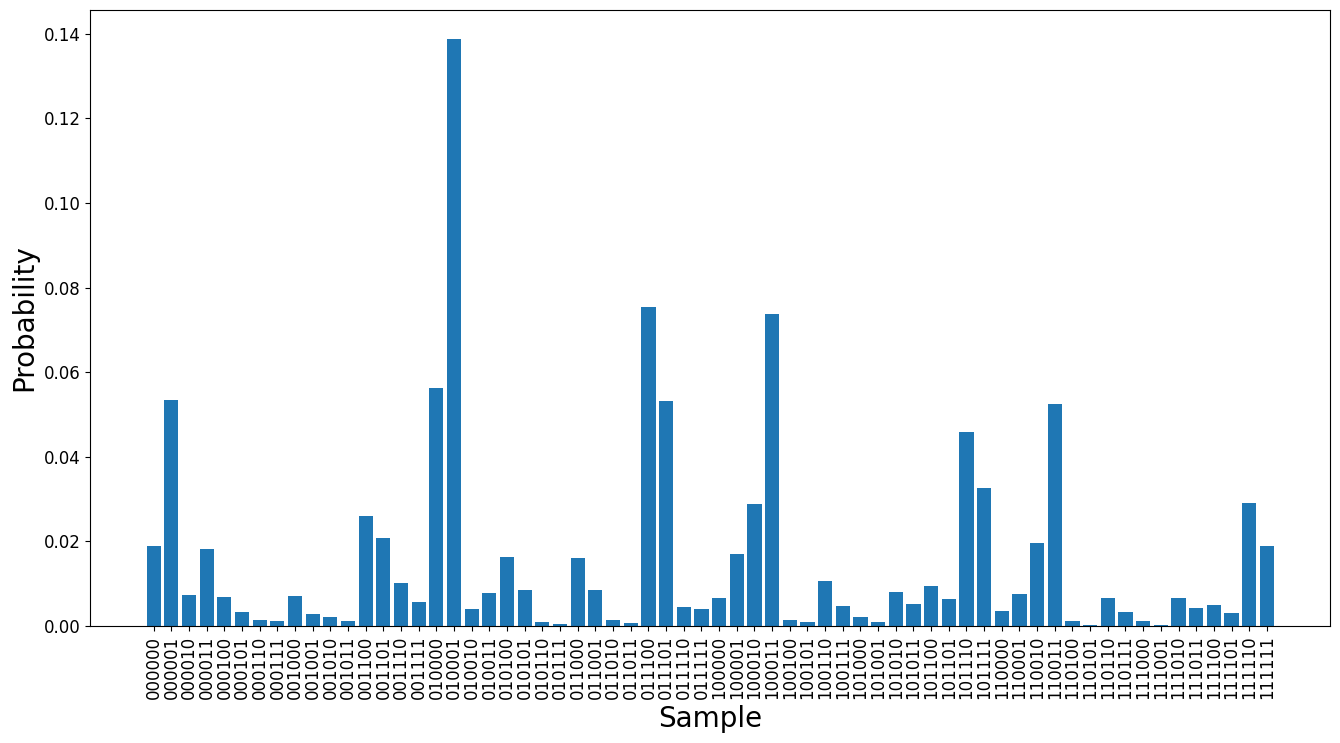

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("seaborn-v0_8-colorblind")
labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(probs))]

plt.bar(range(2**wires), probs.values())
plt.xticks([i for i in range(len(probs))], labels, rotation="vertical", size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

From the plot, it is clear that the sample ``101110`` has the greatest probability. Since each qubit corresponds to a node, this sample selects the nodes ``[0, 2, 3, 4]`` to form a subgraph. Let's check if this is a clique, i.e., if all of the nodes are connected:

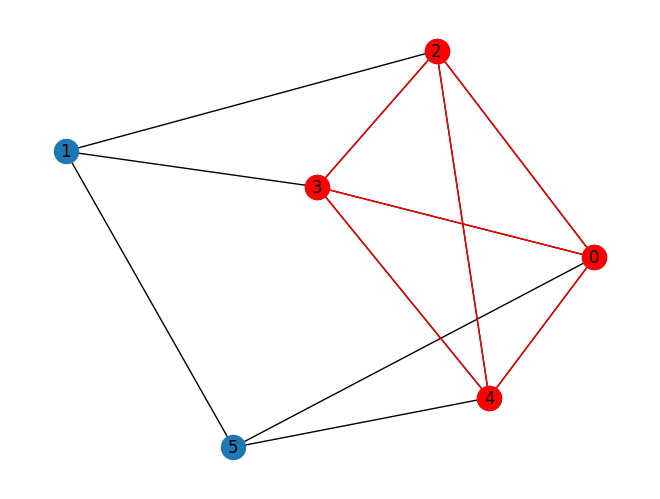

In [13]:
sub = g.subgraph([0, 2, 3, 4])
nx.draw(g, pos=positions, with_labels=True)
nx.draw(sub, pos=positions, node_color="r", edge_color="r")

Great, this is a clique! Moreover, it is the *largest* clique in this six-node graph. QAOA, using PennyLane and Braket, has helped us to solve the maximum clique problem!

## Scaling up QAOA for larger graphs with hybrid jobs

We have seen how we can use PennyLane on Braket to solve graph optimization problems with QAOA. However, we have so far restricted to a simple six-node graph and used the local Braket device. Let's now be more ambitious and try to solve an optimization problem on a 18 node graph! We will use [Amazon Braket Hybrid Jobs](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html) to scale up the classical resources, and run the entire algorithm asynchronously. 

In [14]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

task_tracker = Tracker().start()  # track Braket tasks costs

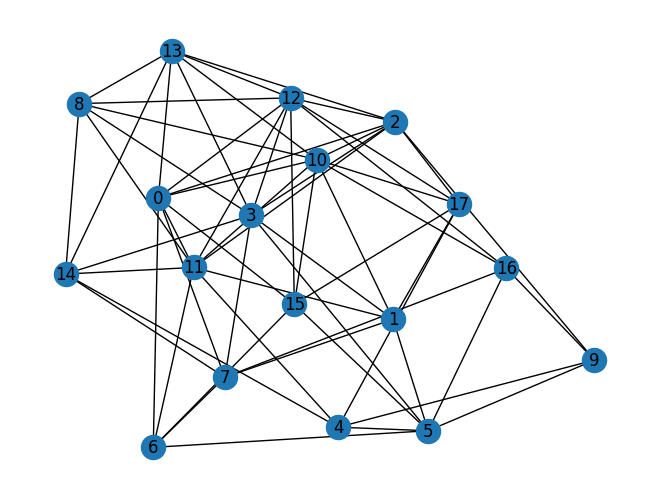

In [15]:
import networkx as nx

nodes = wires = 18
edges = 60
seed = 1967

g = nx.gnm_random_graph(nodes, edges, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions)

A 18 node graph (which maps to the same number of qubits) definitely puts us in a regime where the local simulator will be slow to execute. As we have discussed in the [parallelization tutorial](../1_Parallelized_optimization_of_quantum_circuits/1_Parallelized_optimization_of_quantum_circuits.ipynb), this slowness will be compounded when it comes to training the circuit, with each optimization step resulting in multiple device executions due to calculation of the gradient. Thankfully, the remote SV1 simulator is highly suited to speeding up gradient calculations through parallelization or adjoint differentiation. We now show that this makes training the circuit for QAOA solvable within a reasonable time.

Let's first load a new device:

In [16]:
from braket.devices import Devices

device_arn = Devices.Amazon.SV1
# device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1" # alternatively use the device ARN

In [17]:
dev = qml.device("lightning.qubit", wires=wires)

We now just need to set up the QAOA circuit and optimization problem in the same way as before. However, we will switch to a new optimization problem to keep things interesting: aiming to solve maximum cut, with the objective of partitioning the graph's nodes into two groups so that the greatest number of edges are shared between the groups (see the image below). This problem is NP-hard, so we expect it to be tough as we increase the number of graph nodes.

<div align="center"><img src="max-cut.png"/></div>

In [18]:
cost_h, mixer_h = qml.qaoa.maxcut(g)

In [19]:
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

In [20]:
n_layers = 2


@qml.qnode(dev)
def cost_function(params, **kwargs):
    for i in range(wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)

    qml.layer(qaoa_layer, n_layers, params[0], params[1])
    return qml.expval(cost_h)

In [21]:
np.random.seed(1967)

A variety of [optimizers](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html) are available in PennyLane. Let's choose ``AdagradOptimizer``:

In [22]:
optimizer = qml.AdagradOptimizer(stepsize=0.1)

We're now set up to train the circuit! Note, if you are training this circuit yourself, you may want to increase the number of iterations in the optimization loop and also investigate changing the number of QAOA layers.


We create a hybrid job by annotating our main function with `@hybrid_job`. 
This allows us to choose a target QPU for priority queueing, and additional arguments such as the type of classical instances to use. 
In this example, we use an "ml.c5.xlarge" instance. 

Note that creating hybrid jobs is only supported on Python 3.10. For other versions, you may use [scripts](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html) or a [custom container image](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-byoc.html).

In [23]:
import time
from braket.jobs import hybrid_job, InstanceConfig
from braket.jobs.metrics import log_metric

large_instance = InstanceConfig(instanceType="ml.c5.xlarge")


@hybrid_job(device="local:pennylane/lightning.qubit", instance_config=large_instance)
def qaoa_training(iterations, n_layers=2):
    task_tracker = Tracker().start()  # track Braket tasks costs

    dev = qml.device("lightning.qubit", wires=wires)

    @qml.qnode(dev)
    def cost_function(params, **kwargs):
        for i in range(wires):  # Prepare an equal superposition over all qubits
            qml.Hadamard(wires=i)

        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    params = 0.01 * np.random.uniform(size=[2, n_layers])

    for i in range(iterations):
        params, cost = optimizer.step_and_cost(cost_function, params)

        # Record the value of the cost function with each iteration
        log_metric(metric_name="cost", value=cost, iteration_number=i)

        # Additionally, keep track of cost in USD for Braket tasks
        braket_task_cost = float(
            task_tracker.qpu_tasks_cost() + task_tracker.simulator_tasks_cost()
        )
        log_metric(metric_name="braket_cost", value=braket_task_cost, iteration_number=i)

    return {
        "parameters": params,
        "final_cost": cost_function(params),
        "braket_tasks_cost": task_tracker.qpu_tasks_cost() + task_tracker.simulator_tasks_cost(),
    }

In the next cell, we create the hybrid job by calling the function as usual. The function arguments are logged as hyperparamters for the hybrid job. 

<div class="alert alert-block alert-warning">
<b>Caution:</b> Running the following cell will take a long time and will result in <a href="https://aws.amazon.com/braket/pricing/">usage fees</a> charged to your AWS account. Only uncomment the cell if you are comfortable with the potential wait-time and costs. We recommend monitoring the Billing & Cost Management Dashboard on the AWS console and being aware that hybrid jobs involving a large number of qubits can be costly.
</div>

In [24]:
job = qaoa_training(iterations=5, n_layers=2)
print(job)

AwsQuantumJob('arn':'arn:aws:braket:us-west-1:961591465522:job/qaoa-training-1697141494101')


The hybrid job will be scheduled to run and will appear in the "QUEUED" state. 
If the target is a QPU, the hybrid job will be queued with other hybrid jobs. 
If the target device is not a QPU, the hybrid job should start immediately. 

Note that since the algorithm code is run in a containerized environment, it takes approximately 1 minute to start running your algorithm. 

In [25]:
job.state()

'QUEUED'

Once the state is "COMPLETED", we retrieve the results with 

In [26]:
%%time

job.result()

CPU times: user 337 ms, sys: 18 ms, total: 355 ms
Wall time: 8min 54s


{'parameters': tensor([[-0.01460419,  0.00094966],
         [ 0.0187241 ,  0.00412996]], requires_grad=True),
 'final_cost': array(-30.03947181),
 'braket_tasks_cost': Decimal('0')}

The results included the three values from the return statement of our function.

Additionally, we can retrieve the metrics recorded during the training with:

In [57]:
metrics = job.metrics()
df = pd.DataFrame(metrics)
df = df.groupby("iteration_number").sum().reset_index()
df

,iteration_number,timestamp,cost,braket_cost
0,0.0,3.394283e+09,-29.992536,0.0
1,1.0,3.394284e+09,-27.007548,0.0
2,2.0,3.394284e+09,-29.993231,0.0
3,3.0,3.394284e+09,-30.002011,0.0
4,4.0,3.394284e+09,-30.009532,0.0


The metrics are plotted below. 

Text(0, 0.5, 'cost function')

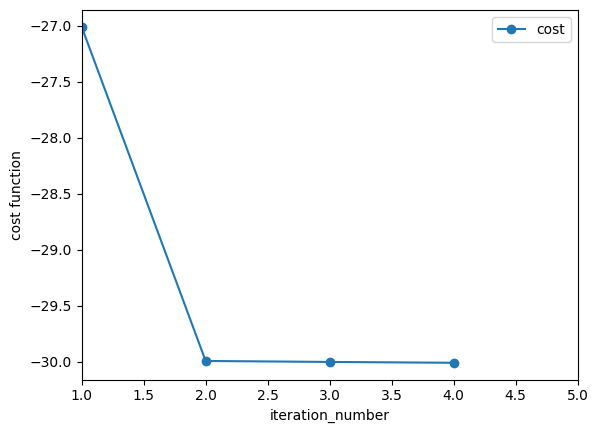

In [68]:
# Plotting the convergence of the loss function metric
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

df.sort_values(by=["iteration_number"]).plot(x="iteration_number", y="cost", marker="o")
plt.xlim(1, 5)
plt.ylabel("cost function")

This example shows us that a 18-qubit QAOA problem can be trained using the "lightning.qubit" with adjoint gradients by using hybrid jobs. 

<div class="alert alert-block alert-info">
<b>What's next?</b> See if you can analyze the trained QAOA circuit for the 18-node graph by adapting the earlier analysis. Also, check out the followup tutorial on quantum chemistry.
</div>

In [36]:
job_cost = job.result()["braket_tasks_cost"]

print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(f"Estimated cost to run this example: {job_cost :.3f} USD")

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.000 USD
